In [89]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

In [34]:
train_dataset, test_dataset= kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()
_, _, _, _, _, test_true = kaggle.load_train_set()

### GoogLeNet

In [41]:
class GoogLeNetHyperModel(kt.HyperModel):
    def inception_layer(self, input, f1, f3_in, f3_out, f5_in, f5_out, pool_out, dropout=0):
        conv1 = layers.Conv2D(
            f1, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        
        conv3 = layers.Conv2D(
            f3_in, (1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        conv3 = layers.Conv2D(
            f3_out, kernel_size=(3,3), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(conv3)
        
        conv5 = layers.Conv2D(
            f5_in, (1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        conv5 = layers.Conv2D(
            f5_out, kernel_size=(5,5), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(conv5)
        
        pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
        pool = layers.Conv2D(
            pool_out, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(pool)
        
        layer_out = layers.concatenate([conv1, conv3, conv5, pool])

        if dropout == 0:
            return layer_out
        else:
            return layers.Dropout(dropout)(layer_out)
    
    def maxpool_layer(self, input):
        return layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(input)

    def conv_layer(self, input, filter, kernel):
        return layers.Conv2D(
            filters=filter, kernel_size=(kernel,kernel), padding='same',
            kernel_initializer=keras.initializers.HeNormal())(input)

    def build(self, hyperparameters):
        input_layer = layers.Input(shape=(96, 96, 1))

        # Input 2x normal convolution
        output = self.conv_layer(input_layer, 64, 7)
        output = self.maxpool_layer(output)
            # output = tf.nn.local_response_normalization(output)
        output = self.conv_layer(output, 128, 3)
        output = self.maxpool_layer(output)
            # output = tf.nn.local_response_normalization(output)

        # Inception layers, level 1
        output = self.inception_layer(output, 64, 96, 128, 16, 32, 32, dropout=0.1)
        output = self.inception_layer(output, 128, 128, 192, 32, 96, 64, dropout=0.1)
        output = self.maxpool_layer(output)
        output = self.inception_layer(output, 192, 96, 208, 16, 48, 64, dropout=0.1)

        # Auxilliary prediction layer
        output = layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(output)
        output = self.conv_layer(output, 128, 1)
        output = layers.Flatten()(output)
        output = layers.Dense(
            512, activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.003))(output)

        # Final output
        output= layers.Dropout(0.7)(output)
        output = keras.layers.Dense(11)(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(0.0001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
        
        return model


Epoch 1/30
149/149 [==============================] - 94s 574ms/step - loss: 3.9780 - accuracy: 0.2154 - val_loss: 3.5325 - val_accuracy: 0.3209
Epoch 2/30
149/149 [==============================] - 83s 560ms/step - loss: 3.4798 - accuracy: 0.3011 - val_loss: 3.2712 - val_accuracy: 0.3772
Epoch 3/30
149/149 [==============================] - 83s 554ms/step - loss: 3.2898 - accuracy: 0.3384 - val_loss: 3.1473 - val_accuracy: 0.4041
Epoch 4/30
149/149 [==============================] - 76s 509ms/step - loss: 3.1328 - accuracy: 0.3711 - val_loss: 2.9831 - val_accuracy: 0.4188
Epoch 5/30
149/149 [==============================] - 76s 509ms/step - loss: 2.9794 - accuracy: 0.4078 - val_loss: 2.8182 - val_accuracy: 0.4697
Epoch 6/30
149/149 [==============================] - 81s 543ms/step - loss: 2.8483 - accuracy: 0.4333 - val_loss: 2.7138 - val_accuracy: 0.4701
Epoch 7/30
149/149 [==============================] - 82s 554ms/step - loss: 2.7135 - accuracy: 0.4638 - val_loss: 2.6048 - val_ac

In [ ]:
# Load existing model if wanted, otherwise create new
use_existing_model = True
model_filepath = 'models/model3/saved_model'
if use_existing_model:
    temp_model = keras.models.load_model(model_filepath)
else:
    temp_model = GoogLeNetHyperModel().build(None)
    # temp_model.summary()

# Early stopping
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
]

# Fit model (can continue from loaded weights)
history = temp_model.fit(
    train_dataset.batch(64).cache(), 
    validation_data=test_dataset.batch(64).cache(),
    epochs=30, callbacks=callbacks, verbose=1)

# Save model
temp_model.save(model_filepath)

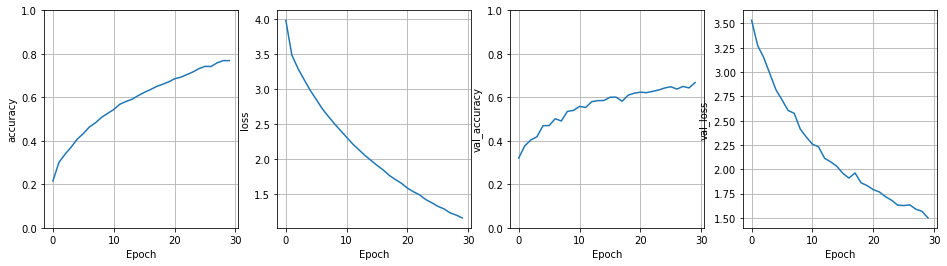

In [42]:
kaggle.plot_model_history(
    history, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Evaluate model

Accuracy: 0.6682


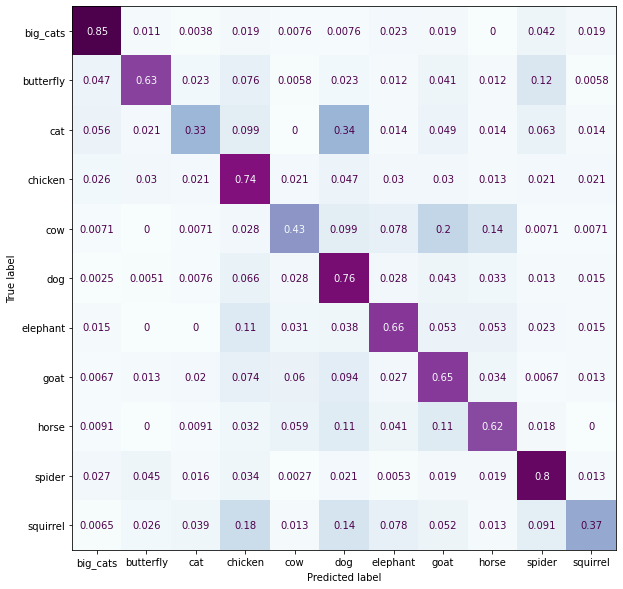

In [56]:
test_pred_raw = temp_model.predict(test_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(test_pred, test_true)
kaggle.plot_confusion_matrix(test_true, test_pred)

### Get labels for Kaggle

In [ ]:
true_test_pred = np.argmax(temp_model.predict(x_test_real), axis=1)

kaggle.save_test_pred('models\model3\model3_pred.csv', true_test_pred)